** chapter 02 End-to-End Machine Learning Project **

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the data

本章中的数据集为 StatLib  的加州房产价格，是基于1990年加州普查的数据。
数据包含每个街区组的人口、收入中位数、房价中位数等。

本章的任务是利用该数据集，建立一个加州房价模型，然后利用这个模型来预测任何其他街区的房价中位数。

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# execute once！
fetch_housing_data()

## 现对数据有个初步认识

In [5]:
datapath = os.path.join("datasets", "housing", "")
housing = pd.read_csv(datapath + "housing.csv")
housing.head() # first 5 rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


可以看到每个数据有10个属性值：经度、纬度、房龄中位数、总房间数、总我市数、人口数、家庭数、收入中位数、房价中位数以及离海距离。

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


数据集中共有20640个实例，我们注意到总房间数这一项只有20433个非空置，这意味着有207个街区缺少该项属性值，后面我们需要对其进行处理。

从上面我们可以注意到“离大海距离”这一项不是数值，而是表示某项属性的字段，那么我们可以使用`value_counts()`方法查看该项中有哪些类别：

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe() # 显示数值类属性的概括

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`count`、`mean`、`std`、`min`和`max`都很好理解，需要注意的就是计算这些值时，是忽略空值的。
百分数指的是小于该值的百分比。例如：25%的房子年龄中位数小于18

另一种快速了解数据的方法是画出每类数据的柱状图。

Saving figure attribute_histogram_plots


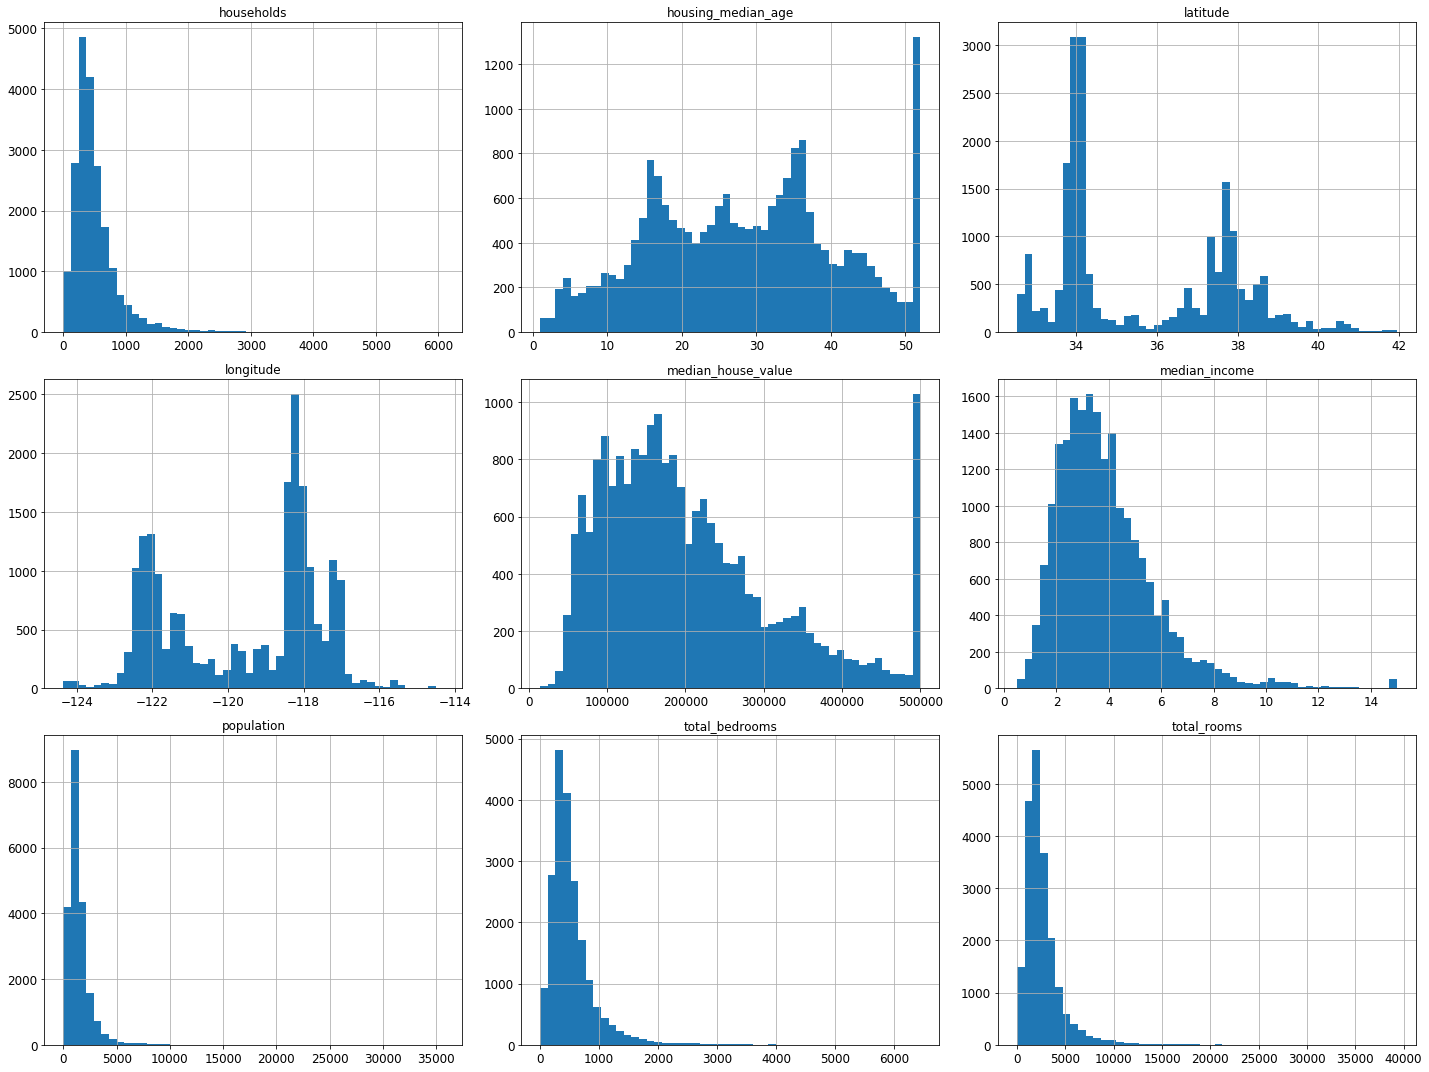

In [9]:
housing.hist(bins=50, figsize=(20, 15))
save_fig("attribute_histogram_plots")
plt.show()

注意到柱状图中的一些特点：
1. 首先，收入中位数不是以美元（USD）为单位，可知数据是家冷啊缩放调整的，过高收入会变成15（实际为15.0001），过低的会变为5（实际为0.499）。在机器学习中对数据进行了预处理很正常，但是我们要知道数据是如何进行处理的。

2. 房屋年龄中位数和房屋价值中位数也都设了上限，对于后者可能是个严重的问题，因为这是我们的目标属性（label）。这样学习得到的模型预测的值可能不会超过这个上限。若需要明确的预测值，那么即使超过500000美元，我们可以有两个选项：
    - 对于设定了上限的数据，重新收集合适的标签
    - 将这些街区的数据从数据集（训练集和测试集）中移除
    
3. 属性具有不同的度量。这涉及到特征缩放的问题。

4. 最后，许多柱状图的尾巴过长，对于机器学习的假设而言，会使检测规律变得更难。我们会尝试变换处理这些属性，使其变为正态分布。

## 创建测试集

在进一步查看数据之前，我们需要将测试集分割出来，这是因为我们的大脑是一个善于发现规律的系统，如果提前查看了测试集，就会不经意的按照测试集中规律来选择某个特定的机器学习模型，当你使用测试集来评估模型时，就会使结果过于乐观，而实际部署的系统表现就会差，这称为数据透视偏差。

理论上，创建测试集只需要随机挑选一些实例，为整个数据集的20%。

In [10]:
np.random.seed(2018)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


若不设定固定的随机数种子，那么每次就会产生不同的测试集，多次运行之后，你可能就会得到整个数据集，这是需要避免的。

解决方法之一就是设定固定的随机数种子，以产生相同的洗牌指数（shuffled indices）。

但若数据集更新了，该方法就会失效。一种通常的解决办法就是使用每个实例的ID（每个实例ID固定且唯一）来判断该实例是否应该放入测试集中。
例如：可以计算出每个实例ID的哈希值，只保留其最后一个字节，若该字节小于51（约为256的20%），就将其放入测试集中，这样可以保证在多次运行中测试集保持不变，即使更新了数据集，新的测试集中会包含新实例中的20%，但不会有之前位于测试集中的实例

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
# 使用行索引作为ID
housing_with_id = housing.reset_index() # add an "index" column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

这里使用行索引作为唯一识别码，那么需要保证新数据置于现有数据的尾部，且没有行被删除。若做不到，则可以使用最稳定的特征来创建唯一识别码，例如街区的经度和纬度在几百万年内基本是不会改变的，所以可以将两者结合成一个ID

In [26]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

`scikit-learn` 提供了一些函数，可以用多种方式将数据集分割为多个子集。最简单的函数是 `train_test_split`，它的作用和之前的函数 `split_train_test`很像，并带有其他的一些功能。首先，其`random_state`参数可以设定随机数种子；第二，可以将种子函数传递给多个行数相同的数据集，可以在相同的索引上分割数据集。这个功能非常有用，当你的标签值放在另一个`DataFrame`中的时候。

In [27]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=2018)

目前为止，我们采用的都是纯随机的取样方法。当数据集很大时（尤其是和属性数相比），这通常的是可行的。但若数据集不大，就会有采样偏差的风险。

假设专家告诉你，收入中位数是预测房价中位数非常重要的属性。那么你的测试集可能需要包含代表整体数据集中的多种收入分类。但收入中位数是一个连续的数值属性，因此，首先需要创建一个收入类别属性。再仔细的看一下收入中位数的柱状图：

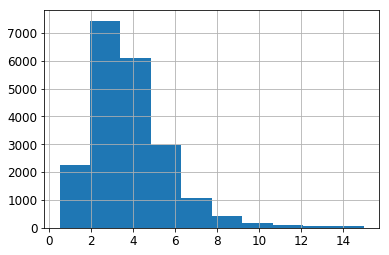

In [40]:
housing["median_income"].hist()
plt.show()

大多数的收入中位数在2～5万美元之间，但有一些收入中位数超过了6。我们要保证每个分层都要有足够的实例位于数据之中，否则对分层重要性的评估就会有偏差。这意味着不能有过多的分层，且每个分层要足够大。这里通过将中位数除以1.5来创建一个收入类别属性，用 `ceil` 对值舍入以产生离散的分类，然后将所有大于5的分类归入到分类5

In [41]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

现在就可以更具收入进行分类，即分层采样。可以使用scikit-learn中的`StratifiedShuffleSplit`类

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2018)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

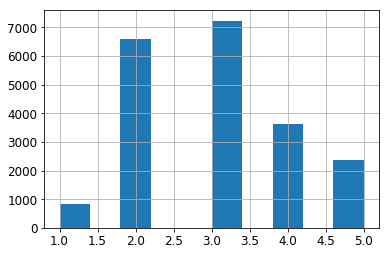

In [50]:
housing["income_cat"].hist()

现在可以在完整的房产数据集中查看收入分类的比例：

In [48]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [51]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

可以看到，测试集中的收入分类比例与整个数据集的比例是一样的

In [52]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=2018)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100



In [53]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.038033,-4.501217,-0.243309
2.0,0.318847,0.318798,0.324612,1.808236,-0.015195
3.0,0.350581,0.350533,0.338905,-3.330569,-0.013820
4.0,0.176308,0.176357,0.182171,3.325089,0.027480
5.0,0.114438,0.114583,0.116279,1.608806,0.127011


上表中对比了总数据集、分层采样的测试集、纯随机采样测试集的收入分类比例。可以看到分层采样测试集的收入分类比例几乎与总数据集相同，而随机采样测试集偏差严重。

现在我们删除 `income_cat` 属性，使数据回到初始状态：

In [54]:
for s in (strat_train_set, strat_test_set):
    s.drop(["income_cat"], axis=1, inplace=True)

测试集的生成是机器学习过程从十分重要的一部分，生成测试集的过程对于后面的交叉验证十分有帮助。

## 数据可视化

目前，我们知识快速查看了数据，对要处理的数据有了整体了解，现在的目标是更深入的探索数据。

首先，将测试集放在一边，只对训练集进行探索。若训练集很大，我们就需要再采样出来一个探索集，保证操作方便快捷。在这个案例中，训练集很小，我们可以在全集上直接工作。这里现创建一个副本，以免损伤训练集

In [56]:
housing = strat_train_set.copy()

数据中存在经纬度，所以将数据以地理坐标的形式进行可视化是不错的选择

Saving figure housing_prices_scatterplot


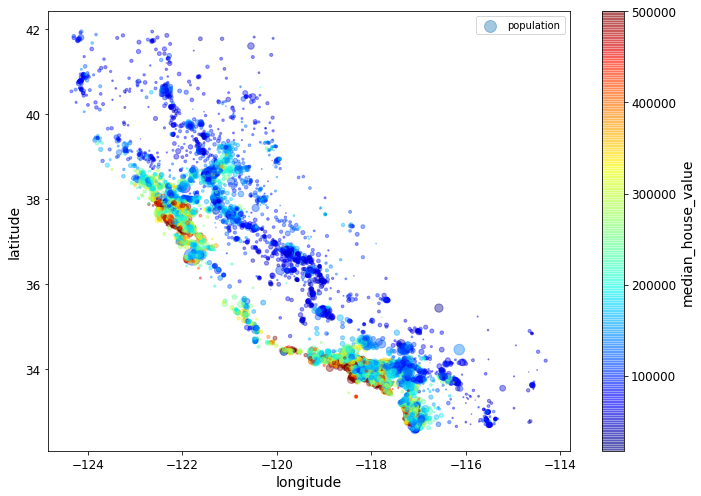

In [58]:
import matplotlib.image as mpimg


housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10, 7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

Saving figure california_housing_prices_plot


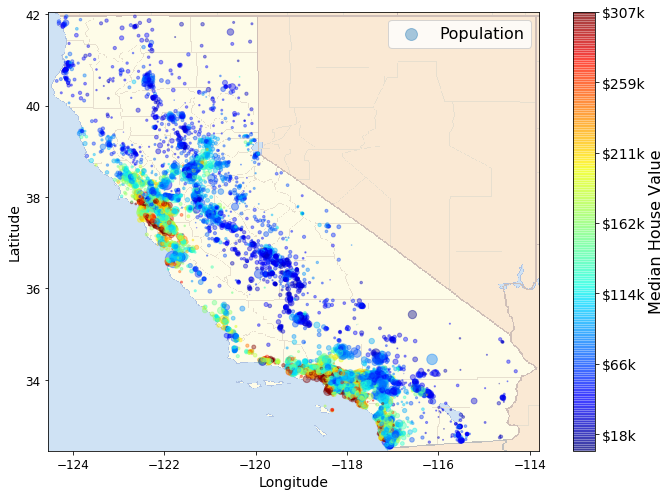

In [61]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

图中每个圈的半径表示街区人口（选项`s`）,颜色代表价格（选项`c`）。

可以看出房价与位置以及人口密度关系密切。

In [18]:
corr_mtx = housing.corr()

In [19]:
corr_mtx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


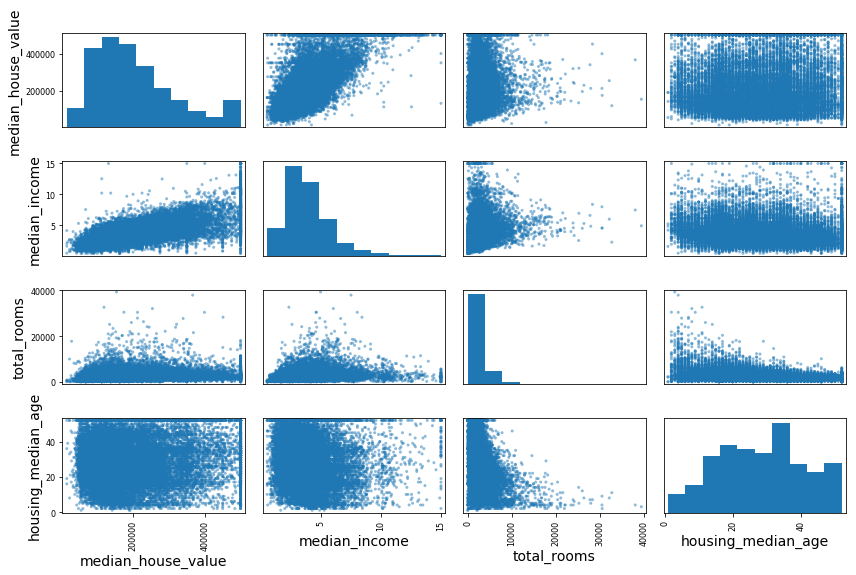

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


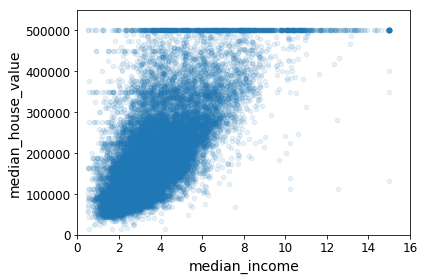

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [22]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [23]:
corr_mtx = housing.corr()
corr_mtx["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

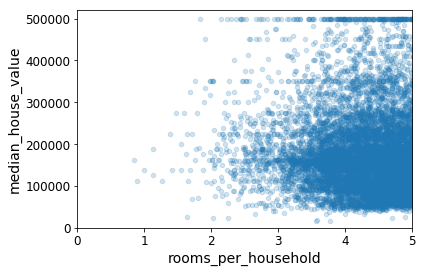

In [24]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
            alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [25]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333
